In [1]:
import collections
import itertools
import math
import pickle
import re
from datetime import datetime
from functools import lru_cache
from pprint import pprint
from typing import Dict, List

import matplotlib
import matplotlib.pyplot as plt
import mwapi
import numpy as np

In [2]:
session = mwapi.Session('https://de.wikipedia.org', user_agent="PAWS-TechWishes")

**Name of the survey page – edit to apply to new survey**

In [3]:
pagetitle = "Technische Wünsche 2020 Themenschwerpunkte"
basesite = "Wikipedia:Umfragen/" + pagetitle + "/"
basesite_without_prefix = "Umfragen/" + pagetitle + "/"

# Helperfunctions

## Prettyprinting function

In [4]:
def print_comp_table(results: Dict[str, int], count: int, overall_results: collections.OrderedDict):
    '''print a table listing the result in percentage and the difference to the total results'''
    for key, overall_percentage in overall_results.items():
        percentage = 100 * results[key] / count
        print("{:<60}\t{:.2f}%\t\t{:+.2f}%".format(key, percentage, percentage - overall_percentage))

In [5]:
def cprint(c: collections.Counter, reverse=True):
    '''Pretty print a Counter: sored and aligned'''
    size = max([len(str(k)) for k in c.keys()])
    for key in sorted(c, key=lambda k: c[k] or "-", reverse=reverse):
        print("%s:" % str(key).rjust(size), c[key])

In [6]:
def lprint(l: List[str]):
    '''Pretty print a list of strings'''
    for li in l:
        print("*", li)

## Get Wikitext

In [7]:
def getwikitext(pagetitle) -> str:
    """ Get the wikitext code of a page"""
    result = session.get(action = "query",
                         prop   = "revisions",
                         rvprop = "content",
                         rvslots= "main",
                         rvlimit= 1,
                         titles = pagetitle
                        )
    pages = result["query"]["pages"]
    return next(iter(pages.values()))["revisions"][0]["slots"]["main"]["*"]

## Extract the usernames from the wikitext

Todo: Check if all users are found

In [8]:
def extractusers(text) -> List[str]:
    """Find all usernames in the text"""
    res = re.findall(r"(Benutzer|Benutzerin|User):([^]|/]+)", text, re.I)
    return list(map(lambda u: u[1], res))

## Dummy class
Am mock class for a nonexistent date for clearer code

In [9]:
class Fake_Date():
    year = -1
    month = -1
    day = -1

# Get topic areas
Get the list of all topic areas, by getting all subpages of ther survey

In [10]:
result = session.get(action       = "query",
                     generator    = "allpages",
                     gapnamespace = 4,
                     gaplimit     = "max",
                     format       = "json",
                     gapprefix    = basesite_without_prefix)
pages = result["query"]["pages"]
areas = [page[1]["title"].split("/")[-1] for page in pages.items()]
if "Test" in areas:
    areas.remove("Test")
if "Vorlage Themenschwerpunkt" in areas:
    areas.remove("Vorlage Themenschwerpunkt")

In [11]:
lprint(areas)

* Bessere Unterstützung von Geoinformationen
* Bessere Unterstützung von Grafik, Audio, Video & Co
* Einfach einheitliche Typografie in Artikeln erzeugen
* Fehler bei der Arbeit mit Belegen reduzieren
* Hilfestellung beim Bearbeiten von Artikeln
* Tools leichter entwickeln und finden
* Vandalismus und destruktive Handlungen besser bekämpfen
* Von Inhaltsänderungen erfahren, die mich interessieren
* Zusammenarbeit on-Wiki leichter machen


# Count votes

In [12]:
voters_per_area: Dict[str, List[str]] = {}
votes_by_user = collections.defaultdict(lambda: [])
all_voters = set()
total_votes = 0
for area in areas:
    source = getwikitext(basesite + area)
    voters = set(extractusers(source))
    for user in voters:
        votes_by_user[user].append(area)
        total_votes += 1
    voters_per_area[area] = voters
    all_voters |= set(voters)
    del voters # make sure to not accidentially use it bellow

In [13]:
# Test with one user
lprint(votes_by_user["MichaelSchoenitzer"])

* Bessere Unterstützung von Grafik, Audio, Video & Co
* Einfach einheitliche Typografie in Artikeln erzeugen
* Tools leichter entwickeln und finden
* Zusammenarbeit on-Wiki leichter machen


In [14]:
# Results in percentage as ordered dictionary
results = collections.OrderedDict()
for key, num in sorted(voters_per_area.items(), key=lambda area: len(area[1]), reverse=True):
    results[key] = 100 * len(num) / len(all_voters)

In [15]:
def count_votes(usernames):
    '''Count the votes for a given subclass of users.'''
    votes = {}
    for area, voter in voters_per_area.items():
        if area == "Test" or area == "Vorlage Themenschwerpunkt":
            continue
        votes[area] = 0
        for u in voter:
            if u in usernames:
                votes[area] += 1
    return votes

## Number of voters

In [16]:
print(len(all_voters))

1010


## Number of votes

In [17]:
print(total_votes)

1622


## Average number of votes per user

In [18]:
print("{:.2f}".format(total_votes / len(all_voters)))

1.61


# Retrieve information about user

To get all informations we need, we will have to query both: the information about the local user account, as well as the information about the global user account.
While the first can be queried in batches of 50 users, the global user informations must be queried with one Query at a time…

In [19]:
def getlocaluserinfo(users):
    """Get the informations about all users in the list"""
    # Split in batches of 50 users, since that is the amount the API allows to query per request
    def get50(users):
        assert users <= 50
        result = session.get(action="query",
                             list="users",
                             ususers=users,
                             usprop="groups|groupmemberships|rights|editcount|registration|emailable|gender|implicitgroups|blockinfo"
                            )
        return result["query"]["users"]
    
    unserinfo = []
    for i in range(math.ceil(len(users) / 50)): 
         unserinfo += get50(users[i*50:(i+1)*50])
    return unserinfo

In [20]:
@lru_cache(maxsize=2000)
def _getglobaluserinfo(user):
    result = session.get(action = "query",
                        list    = "users",
                        meta    = "globaluserinfo",
                        guiuser = user,
                        guiprop = "editcount|groups|merged|rights|unattached"
                         )
    return result["query"]["globaluserinfo"]

In [21]:
def getglobaluserinfo(users):
    info = []
    for user in users:
        try:
            new = _getglobaluserinfo(user)
            info.append(new)
        except mwapi.session.APIError as e:
            print(e)
    return info

In [22]:
commons = mwapi.Session('https://commons.wikimedia.org', user_agent="foobar")
@lru_cache(maxsize=2000)
def get_commons_uploads(user):
    all_results = []
    result = commons.get(action="query",
                             list="allimages",
                             aisort= "timestamp",
                             aiuser= user,
                             ailimit= "max"
                            )
    while True:
        all_results += result["query"]["allimages"]
        cont = result.get("continue", {}).get("continue")
        if cont != "-||":
            break
        else:
            result = commons.get(action="query",
                             list="allimages",
                             aisort= "timestamp",
                             aiuser= user,
                             ailimit= "max",
                             aicontinue=result["continue"]["aicontinue"]
                            )
            
        
    return len(all_results)

## Querry the information

Retrieve the information about all users that voted. Especially the information about the global account may take a long time. Also the retrieved informations will be from the date the code it executed, not from the date of the survey. For those reasons we save the querried data to disk, so that we can reuse it when running the script again. **Use the following variable to switch between both "modes".**

In [23]:
# If true, will query the userinformation and store them in a "pickle" file,
# If false, will read the pickle file
query_info = False

In [24]:
if query_info:
    localuserinfo = getlocaluserinfo(list(all_voters))
    with open("local_userinfo.pickle", "wb") as f:
        pickle.dump(localuserinfo, f)
else:
    with open("local_userinfo.pickle", "rb") as f:
        localuserinfo = pickle.load(f)

In [25]:
if query_info:
    print("Querying global user information, this might take a while…")
    globaluserinfo = getglobaluserinfo(list(all_voters))
    with open("global_userinfo.pickle", "wb") as f:
        pickle.dump(globaluserinfo, f)
else:
    with open("global_userinfo.pickle", "rb") as f:
        globaluserinfo = pickle.load(f)

## Join local and global userinfo

In [26]:
unified_userinfo = {}
for user_data in localuserinfo:
    name = user_data['name']
    unified_userinfo[name] = user_data
    unified_userinfo[name]['first_registration'] = Fake_Date()

In [27]:
for user_data in globaluserinfo:
    if 'name' not in user_data.keys():
        continue
    name = user_data['name']
    unified_userinfo[name]['home'] = user_data['home']
    unified_userinfo[name]['global_groups'] = user_data['groups']
    unified_userinfo[name]['global_rights'] = user_data['rights']
    unified_userinfo[name]['global_editcount'] = user_data['editcount']
    unified_userinfo[name]['merged'] = user_data['merged']
    globaldate = unified_userinfo[name].get('registration')
    localdate = user_data.get('registration')
    if globaldate and localdate:
        if isinstance(globaldate, datetime):    # Hack, not needed if script is running properly from start
            g = globaldate
        else:
            g = datetime.strptime(globaldate, "%Y-%m-%dT%H:%M:%SZ")
        l = datetime.strptime(localdate, "%Y-%m-%dT%H:%M:%SZ")
        unified_userinfo[name]['first_registration'] = min(g, l)
    elif globaldate:
        unified_userinfo[name]['first_registration'] = datetime.strptime(globaldate, "%Y-%m-%dT%H:%M:%SZ")
    elif localdate:
        unified_userinfo[name]['first_registration'] = datetime.strptime(localdate, "%Y-%m-%dT%H:%M:%SZ")
    else:
        # For unknown reasons the API does not return a registation date for some accounts.
        unified_userinfo[name]['first_registration'] = Fake_Date()

# Get statistics about all voters
Statistics about the voters.

## Userrights

In [28]:
def voters_by_right(right):
    return list(filter(lambda user: right in user.get("groups", []), unified_userinfo.values()))

In [29]:
exsisting_groups = set(itertools.chain(*map(lambda user: user.get("groups", []), unified_userinfo.values())))

In [30]:
for right in exsisting_groups:
    print(right.ljust(16), len(voters_by_right(right)))

noratelimit      4
user             1004
sysop            25
autoreview       825
autoconfirmed    1004
*                1004
editor           695
interface-admin  4
ipblock-exempt   16
oversight        1
checkuser        1


## Year of registration
For unknown reasons the API does not return me a registation date for some accounts, these will show -1 as registation year.

In [31]:
by_year = collections.Counter(map(lambda user: user.get("first_registration").year, unified_userinfo.values()))
cprint(by_year)
del by_year[-1]

2008: 121
2006: 86
2009: 84
2015: 78
2013: 73
2018: 66
2010: 63
2016: 58
2019: 58
2014: 58
2007: 56
2011: 55
2017: 52
2020: 49
2012: 47
  -1: 6
2005: 1


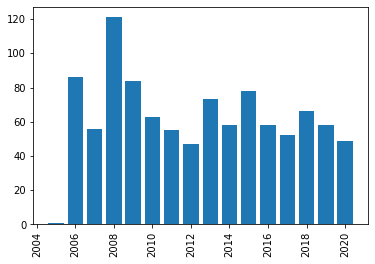

In [32]:
%matplotlib inline
plt.xticks(rotation=90)
_ = plt.bar(*zip(*sorted(by_year.items())))

## Local Editcount
Note: this is the **current** edit count, not from the time of the survey.

In [33]:
def calc_bin(value):
    if value:
        return math.floor(math.log(value, 10))
    return None
by_edc = collections.Counter(map(lambda user: calc_bin(user.get("editcount")), unified_userinfo.values()))
print("Editcounter could not be retrieved:", by_edc[None])
del by_edc[None]
for step in sorted(by_edc.keys()):
    print("Between {:>5} and {:>7} edits: {}".format(10**step-1, 10**(step+1), by_edc[step]))

Editcounter could not be retrieved: 8
Between     0 and      10 edits: 40
Between     9 and     100 edits: 126
Between    99 and    1000 edits: 299
Between   999 and   10000 edits: 341
Between  9999 and  100000 edits: 182
Between 99999 and 1000000 edits: 15


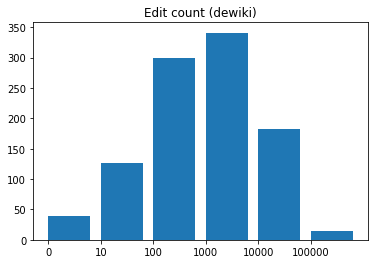

In [34]:
%matplotlib inline
fig1, ax1 = plt.subplots()
ax1.set_title("Edit count (dewiki)")
_ = ax1.bar(*zip(*sorted(by_edc.items())), tick_label=[0, 10, 100,1000,10000,100000], align="edge")

## Global Editcount
Note: this is the **current** edit count, not from the time of the survey.

In [36]:
def calc_bin(value):
    if value:
        return math.floor(math.log(value, 10))
    return None
by_edc = collections.Counter(map(lambda user: calc_bin(user.get("global_editcount")), unified_userinfo.values()))
print("Editcounter could not be retrieved:", by_edc[None])
del by_edc[None]
for step in sorted(by_edc.keys()):
    print("Between {:>7} and {:>9} edits: {}".format(10**step-1, 10**(step+1), by_edc[step]))

Editcounter could not be retrieved: 7
Between       0 and        10 edits: 27
Between       9 and       100 edits: 101
Between      99 and      1000 edits: 256
Between     999 and     10000 edits: 326
Between    9999 and    100000 edits: 238
Between   99999 and   1000000 edits: 52
Between  999999 and  10000000 edits: 2
Between 9999999 and 100000000 edits: 2


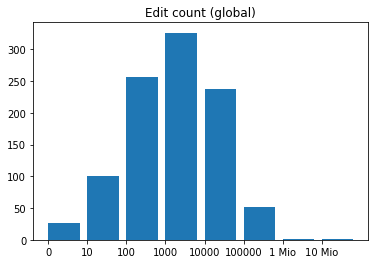

In [37]:
%matplotlib inline
fig1, ax1 = plt.subplots()
ax1.set_title("Edit count (global)")
_ = plt.bar(*zip(*sorted(by_edc.items())), tick_label=[0, 10, 100,1000,10000,100000,'1 Mio','10 Mio'], align="edge")

## "Gender"-Setting
Note: this is **not** necessary the gender of the person

In [38]:
gender = collections.Counter(map(lambda user: user.get("gender", None), unified_userinfo.values()))
cprint(gender)

unknown: 617
   male: 350
 female: 37
   None: 7


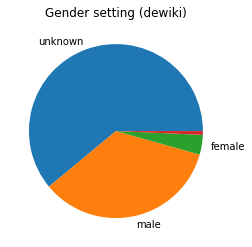

In [39]:
%matplotlib inline
fig1, ax1 = plt.subplots()
ax1.set_title("Gender setting (dewiki)")
_ = plt.pie(gender.values(), labels=gender.keys())
plt.savefig("byGender.svg")

## Home wiki
The "home" wiki of a user. Usually the wiki they registered their account originally. For better visualisation I also plot them with dewiki excluded.

In [40]:
home = collections.Counter(map(lambda user: user.get("home", None), unified_userinfo.values()))
cprint(home)

       dewiki: 871
  commonswiki: 48
       enwiki: 46
 wikidatawiki: 8
         None: 6
mediawikiwiki: 3
       plwiki: 3
       nowiki: 2
   simplewiki: 2
 dewikisource: 2
       itwiki: 2
dewikiversity: 2
       lbwiki: 2
       svwiki: 1
enwikiversity: 1
       iewiki: 1
  dewikibooks: 1
      alswiki: 1
       trwiki: 1
       hrwiki: 1
       frwiki: 1
       nlwiki: 1
   dewikinews: 1
     metawiki: 1
       eowiki: 1
       jawiki: 1
  dewikiquote: 1


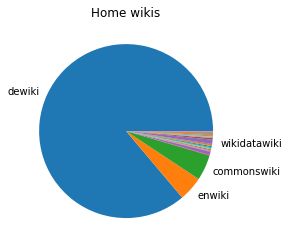

In [41]:
%matplotlib inline
fig1, ax1 = plt.subplots()
labels = [n if v > 5 else '' for n, v in home.items()]
ax1.pie(home.values(), labels=labels)
ax1.set_title("Home wikis")
plt.savefig("byhomewiki.svg")

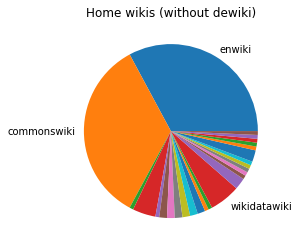

In [42]:
%matplotlib inline
fig1, ax1 = plt.subplots()
del home["dewiki"]
labels = [n if v > 5 else '' for n, v in home.items()]
ax1.pie(home.values(), labels=labels)
ax1.set_title("Home wikis (without dewiki)")
plt.savefig("byhomewiki_o.svg")

# Main wiki
Wiki on which the users made the most edits.

In [43]:
main_wiki = []
for user in unified_userinfo.values():
    if "merged" not in user:
        continue
    main_wiki.append(max(user["merged"], key=lambda w: w["editcount"])["wiki"])
main = collections.Counter(main_wiki)
cprint(main)

       dewiki: 812
  commonswiki: 107
 wikidatawiki: 47
       enwiki: 17
 dewikivoyage: 5
       nowiki: 2
     metawiki: 2
 dewikisource: 2
      alswiki: 2
       itwiki: 2
   simplewiki: 1
dewikiversity: 1
       lbwiki: 1
       iewiki: 1
       etwiki: 1
  dewikibooks: 1
mediawikiwiki: 1


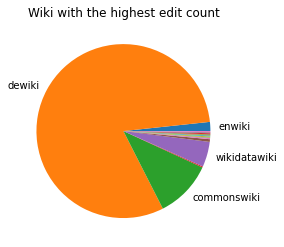

In [44]:
%matplotlib inline
fig1, ax1 = plt.subplots()
labels = [n if v > 5 else '' for n, v in main.items()]
_ = ax1.pie(main.values(), labels=labels)
ax1.set_title("Wiki with the highest edit count")
plt.savefig("bymainwiki.svg")

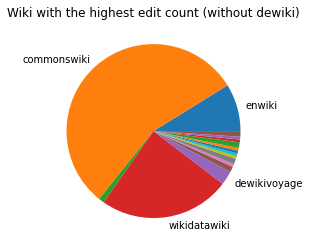

In [45]:
del main["dewiki"]
fig1, ax1 = plt.subplots()
labels = [n if v > 3 else '' for n, v in main.items()]
_ = plt.pie(main.values(), labels=labels)
ax1.set_title("Wiki with the highest edit count (without dewiki)")
plt.savefig("bymainwiki_o.svg")

# How did certain usergroups vote?
In the following I define a list of user groups and show how they voted and compare them to the total results.

## New users
Users that created their account within the last year.

In [46]:
newusers = []
for username, userdata in unified_userinfo.items():
    registration = userdata["first_registration"]
    if isinstance(registration, Fake_Date):
        continue
    time_delta = datetime.now() - registration
    if time_delta.days < 365*1.5:
        newusers.append(username)

In [47]:
len(newusers)

65

How did this user group vote and what's the difference in percent points to the general election results:

In [64]:
print_comp_table(count_votes(newusers), len(newusers), results)

Bessere Unterstützung von Geoinformationen                  	27.69%		-0.82%
Fehler bei der Arbeit mit Belegen reduzieren                	15.38%		-7.29%
Einfach einheitliche Typografie in Artikeln erzeugen        	24.62%		+2.14%
Tools leichter entwickeln und finden                        	20.00%		+1.68%
Vandalismus und destruktive Handlungen besser bekämpfen     	9.23%		-6.12%
Von Inhaltsänderungen erfahren, die mich interessieren      	15.38%		+0.63%
Bessere Unterstützung von Grafik, Audio, Video & Co         	10.77%		-3.79%
Hilfestellung beim Bearbeiten von Artikeln                  	15.38%		+1.42%
Zusammenarbeit on-Wiki leichter machen                      	12.31%		+2.31%


## Casual editors
Users that:
* registered at least a year ago and
* made at least 10 edits and
* make on average less then one edit per month

In [65]:
casual_users = []
for username, user_data in unified_userinfo.items():
    registration = user_data["first_registration"]
    if isinstance(registration, Fake_Date):
        continue
    edit_count = user_data.get("editcount", 0)
    time_delta = datetime.now() - registration
    edits_per_month = edit_count / (time_delta.days / 30)
    if time_delta.days > 365 and edit_count > 10 and edits_per_month < 1:
        casual_users.append(username)

In [66]:
len(casual_users)

96

In [67]:
print_comp_table(count_votes(casual_users), len(casual_users), results)

Bessere Unterstützung von Geoinformationen                  	39.58%		+11.07%
Fehler bei der Arbeit mit Belegen reduzieren                	11.46%		-11.21%
Einfach einheitliche Typografie in Artikeln erzeugen        	12.50%		-9.98%
Tools leichter entwickeln und finden                        	13.54%		-4.78%
Vandalismus und destruktive Handlungen besser bekämpfen     	3.12%		-12.22%
Von Inhaltsänderungen erfahren, die mich interessieren      	9.38%		-5.38%
Bessere Unterstützung von Grafik, Audio, Video & Co         	13.54%		-1.01%
Hilfestellung beim Bearbeiten von Artikeln                  	14.58%		+0.62%
Zusammenarbeit on-Wiki leichter machen                      	6.25%		-3.75%


## Powerusers
Users with more than 10'000 edits in german Wikipedia

In [68]:
powerusers = []
for user, user_data in unified_userinfo.items():
    if user_data.get("editcount", 0) > 10000:
        powerusers.append(user)

In [69]:
len(powerusers)

197

In [70]:
print_comp_table(count_votes(powerusers), len(powerusers), results)

Bessere Unterstützung von Geoinformationen                  	27.41%		-1.10%
Fehler bei der Arbeit mit Belegen reduzieren                	31.98%		+9.31%
Einfach einheitliche Typografie in Artikeln erzeugen        	22.84%		+0.37%
Tools leichter entwickeln und finden                        	21.83%		+3.51%
Vandalismus und destruktive Handlungen besser bekämpfen     	21.83%		+6.48%
Von Inhaltsänderungen erfahren, die mich interessieren      	21.32%		+6.57%
Bessere Unterstützung von Grafik, Audio, Video & Co         	12.18%		-2.37%
Hilfestellung beim Bearbeiten von Artikeln                  	11.68%		-2.29%
Zusammenarbeit on-Wiki leichter machen                      	13.20%		+3.20%


## Women

In [71]:
women = []
for user, user_data in unified_userinfo.items():
    if user_data.get("gender", "?") == "female":
        women.append(user)

In [72]:
len(women)

37

In [73]:
print_comp_table(count_votes(women), len(women), results)

Bessere Unterstützung von Geoinformationen                  	10.81%		-17.70%
Fehler bei der Arbeit mit Belegen reduzieren                	37.84%		+15.16%
Einfach einheitliche Typografie in Artikeln erzeugen        	35.14%		+12.66%
Tools leichter entwickeln und finden                        	18.92%		+0.60%
Vandalismus und destruktive Handlungen besser bekämpfen     	8.11%		-7.24%
Von Inhaltsänderungen erfahren, die mich interessieren      	29.73%		+14.98%
Bessere Unterstützung von Grafik, Audio, Video & Co         	8.11%		-6.45%
Hilfestellung beim Bearbeiten von Artikeln                  	13.51%		-0.45%
Zusammenarbeit on-Wiki leichter machen                      	24.32%		+14.32%


## Admins

In [74]:
admin = []
for user, user_data in unified_userinfo.items():
    if "sysop" in user_data.get("groups", []):
        admin.append(user)

In [75]:
len(admin)

25

In [76]:
print_comp_table(count_votes(admin), len(admin), results)

Bessere Unterstützung von Geoinformationen                  	28.00%		-0.51%
Fehler bei der Arbeit mit Belegen reduzieren                	20.00%		-2.67%
Einfach einheitliche Typografie in Artikeln erzeugen        	8.00%		-14.48%
Tools leichter entwickeln und finden                        	20.00%		+1.68%
Vandalismus und destruktive Handlungen besser bekämpfen     	20.00%		+4.65%
Von Inhaltsänderungen erfahren, die mich interessieren      	16.00%		+1.25%
Bessere Unterstützung von Grafik, Audio, Video & Co         	8.00%		-6.55%
Hilfestellung beim Bearbeiten von Artikeln                  	12.00%		-1.96%
Zusammenarbeit on-Wiki leichter machen                      	16.00%		+6.00%


## File Uploader
People who uploaded at least 1000 files to Wikimedia Commons.

In [77]:
commonsusers = []
for user, user_data in unified_userinfo.items():
    for wiki in user_data.get("merged", []):
        if wiki["wiki"] == "commonswiki" and wiki["editcount"] > 1000:
            commonsuploads = get_commons_uploads(user)
            if commonsuploads >= 1000:
                commonsusers.append(user)

In [78]:
len(commonsusers)

118

In [79]:
print_comp_table(count_votes(commonsusers), len(commonsusers), results)

Bessere Unterstützung von Geoinformationen                  	49.15%		+20.64%
Fehler bei der Arbeit mit Belegen reduzieren                	22.88%		+0.21%
Einfach einheitliche Typografie in Artikeln erzeugen        	16.10%		-6.37%
Tools leichter entwickeln und finden                        	23.73%		+5.41%
Vandalismus und destruktive Handlungen besser bekämpfen     	11.86%		-3.48%
Von Inhaltsänderungen erfahren, die mich interessieren      	14.41%		-0.35%
Bessere Unterstützung von Grafik, Audio, Video & Co         	22.03%		+7.48%
Hilfestellung beim Bearbeiten von Artikeln                  	5.93%		-8.03%
Zusammenarbeit on-Wiki leichter machen                      	9.32%		-0.68%


# Ideas for further investigations
- How many people have a common.js?